In [2]:
import numpy as np
from PIL import Image
import cv2
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
import random

In [3]:
class Point():
    def __init__(self, x, y):
        """Defines a point using its physical space coordinates"""
        self.x = x
        self.y = y
        self.hc = self.get_hc()
    @classmethod
    def from_hc(cls, hc):
        """Defines a point from its representation in homogeneous coordinates"""
        if np.isclose(hc[2],0):
            x = hc[0]
            y = hc[1]
        else:
            x = hc[0] / hc[2]
            y = hc[1] / hc[2]
        return cls(x, y)
    def get_hc(self):
        """Returns the point in homogeneous coordinates"""
        return np.array([self.x, self.y, 1])
    def __repr__(self):
        """To string method for debugging"""
        return f"Point(x={self.x}, y={self.y}, hc={self.hc})"

In [4]:
class ImageClass():
    def __init__(self, inpath):
        """Takes a path to an image and opens it while getting the height and width

        Args:
            inpath (file_path string): path to the image to open
        """
        self.filepath = inpath
        self.w = None
        self.h = None
        self.img = None
    
    def get_h_w_img(self):
        self.img = np.array(Image.open(self.filepath))
        self.w = self.img.shape[1]
        self.h = self.img.shape[0]
        
        return self.h, self.w, self.img
    

In [5]:
def get_masked_corners(corners, area_bound, img):
    return corners[(corners[:, 0] >= area_bound) & (corners[:, 0] <= img.shape[0] - area_bound) &
                                (corners[:, 1] >= area_bound) & (corners[:, 1] <= img.shape[1] - area_bound)]

def SSD(m, img1, corners1, img2, corners2, num_matches):
    area_bound = m+1
    # Remove boundary points that are outside of the neighborhood search area
    # Make sure to check for the boundaries on all sides of the images
    # Corners is a list of points: [(x1,y1), (x2,y2), (x3,y3), ...]
    masked_corners1 = get_masked_corners(corners1, area_bound, img1)
    masked_corners2 = get_masked_corners(corners2, area_bound, img2)
    
    matching_points = []
    for coord1 in masked_corners1:
        # Get (m+1) by (m+1) area in the BW image around that corner point
        neighborhood1 = img1[coord1[0]-(area_bound):coord1[0]+(area_bound), coord1[1]-(area_bound):coord1[1]+(area_bound)]
        for coord2 in masked_corners2:
            neighborhood2 = img2[coord2[0]-(area_bound):coord2[0]+(area_bound), coord2[1]-(area_bound):coord2[1]+(area_bound)]
            
            # Calculate the sum of squared distances and add the result to a list to later get the topk
            ssd = np.sum((neighborhood1 - neighborhood2)**2)
            matching_points.append([ssd, [coord1, coord2]])
            
    # Get the top num_matches corner matches (with the highest SSD values first)# Convert to array for easier manipulation
    matching_points = np.array(matching_points, dtype=object)
    
    # Sort matching points by SSD (smallest first)
    sorted_matches = sorted(matching_points, key=lambda x: x[0])
    
    # To store the top correspondences without repeats
    topk_matches = []
    used_coords1 = set()
    used_coords2 = set()
    
    # Iterate over sorted matches and select the top num_matches with unique points
    for match in sorted_matches:
        coord1, coord2 = match[1]
        
        # Ensure no coordinate from coord1 or coord2 is repeated
        if tuple(coord1) not in used_coords1 and tuple(coord2) not in used_coords2:
            topk_matches.append([coord1, coord2])
            used_coords1.add(tuple(coord1))
            used_coords2.add(tuple(coord2))
        
        # Stop when we have enough matches
        if len(topk_matches) == num_matches:
            break
    return topk_matches

def NCC(m, img1, corners1, img2, corners2, num_matches):
    area_bound = m+1
    # Remove boundary points that are outside of the neighborhood search area
    # Make sure to check for the boundaries on all sides of the images
    # Corners is a list of points: [(x1,y1), (x2,y2), (x3,y3), ...]
    masked_corners1 = get_masked_corners(corners1, area_bound, img1)
    masked_corners2 = get_masked_corners(corners2, area_bound, img2)
    
    matching_points = []
    for coord1 in masked_corners1:
        # Get (m+1) by (m+1) area in the BW image around that corner point
        neighborhood1 = img1[coord1[0]-(area_bound):coord1[0]+(area_bound), coord1[1]-(area_bound):coord1[1]+(area_bound)]
        
        for coord2 in masked_corners2:
            neighborhood2 = img2[coord2[0]-(area_bound):coord2[0]+(area_bound), coord2[1]-(area_bound):coord2[1]+(area_bound)]
            # sum(sum((f1 - mu1) * f2 - mu2)
            numerator = np.sum((neighborhood1 - np.mean(neighborhood1)) * (neighborhood2 - np.mean(neighborhood2)))
            
            # sum(sum((f1 - mu1)^2)) * sum(sum((f2 - mu2)^2))
            denom1 = np.sum((neighborhood1 - np.mean(neighborhood1))**2)
            denom2 = np.sum((neighborhood2 - np.mean(neighborhood2))**2)
            
            # sqrt(denom2 * denom2)
            ncc = numerator / ((denom1 * denom2)**(1/2))
            matching_points.append([ncc, [coord1, coord2]])
            
    # Get the top num_matches corner matches (with the highest SSD values first)# Convert to array for easier manipulation
    matching_points = np.array(matching_points, dtype=object)
    
    # Sort matching points by SSD (smallest first)
    sorted_matches = sorted(matching_points, key=lambda x: x[0], reverse=True)
    
    # To store the top correspondences without repeats
    topk_matches = []
    used_coords1 = set()
    used_coords2 = set()
    
    # Iterate over sorted matches and select the top num_matches with unique points
    for match in sorted_matches:
        coord1, coord2 = match[1]
        
        # Ensure no coordinate from coord1 or coord2 is repeated
        if tuple(coord1) not in used_coords1 and tuple(coord2) not in used_coords2:
            topk_matches.append([coord1, coord2])
            used_coords1.add(tuple(coord1))
            used_coords2.add(tuple(coord2))
        
        # Stop when we have enough matches
        if len(topk_matches) == num_matches:
            break
    return topk_matches

In [6]:
class Harris():
    def __init__(self, sigma):
        self.sigma = sigma
        haar_size = int(np.ceil(4*sigma))
        if haar_size % 2 == 1:
            # Odd -> add 1
            # Else this is already the largest even number > 4 sigma
            haar_size += 1
        self.haar_dx = np.hstack((-1*np.ones((haar_size, haar_size//2)), np.ones((haar_size, haar_size//2))))
        self.haar_dy = -1*self.haar_dx.copy().T
        
        # 5sigma by 5sigma neighborhood for calculating the C matrix
        neigh_size = int(np.ceil(5*sigma))
        self.summation_neighborhood = np.ones((neigh_size, neigh_size))
        
        
    def get_matching_interest_points(self, img1_path, img2_path, k, num_matches, similarity_measure="NCC"):
        """Takes in two images and returns a list of interest point matches

        Args:
            img1_path (string): string for the path to one image
            img2_path (string): string for the path of another view of the previous image
            k (scalar): Constant for corner threshold score k in [0.04, 0.06]
            topk: num of matches to keep in corner matching
        Returns:
            match_list (list): list of matching interest points on both images  
        """
        # Open the image pairs
        img1 = np.array(cv2.imread(img1_path))
        img2 = np.array(cv2.imread(img2_path))
        
        # bring the images two greyscale and normalize pixel values to 0,1
        img1_bw = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) / 255
        img2_bw = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) / 255
        
        # Get the threshold response function to find the location of the corners
        threshold_response1 = self.find_corners(img1_bw, k)
        threshold_response2 = self.find_corners(img2_bw, k)
        
        # Convert threshold response to (x,y) coordinate locations of corners: 
        # [(x1, y1), (x2, y2), ..] for non-zero values in the matrix
        corners1 = np.argwhere(threshold_response1)
        corners2 = np.argwhere(threshold_response2)
    
        print(len(corners1))
        # Apply feature similarity measure
        if similarity_measure == "NCC":
            point_matches = NCC(20, img1_bw, corners1, img2_bw, corners2, num_matches)
        elif similarity_measure == "SSD":
            point_matches = SSD(20, img1_bw, corners1, img2_bw, corners2, num_matches)
        else:
            raise ValueError("Options for the similarity measure are: NCC and SSD")
        
        return point_matches
    
    def find_corners(self, img_bw, k):
        # Apply haar filters through convolution
        dx = cv2.filter2D(img_bw, -1, self.haar_dx)
        dy = cv2.filter2D(img_bw, -1, self.haar_dy)
        
        # Get second derivatives, these will be applied along a 5sigmax5sigma neighborhood
        dx2, dy2, dxdy = dx*dx, dy*dy, dx*dy
        
        # Get second degree summations along the neighboorhood area
        sum_dx2 = cv2.filter2D(dx2, -1, self.summation_neighborhood)
        sum_dy2 = cv2.filter2D(dy2, -1, self.summation_neighborhood)
        sum_dxdy = cv2.filter2D(dxdy, -1, self.summation_neighborhood)
        # sum_dydx = cv2.filter2D(dydx, -1, self.summation_neighborhood)
        
        # Calculate the trace and determinant for the threshold ratio
        trace = sum_dx2 + sum_dy2
        det = sum_dx2*sum_dy2 - (sum_dxdy)**2
        
        # Threshold ratio following Harris & Stephens 1988:
        R = det - k*(trace**2)
        
        suppression_map = maximum_filter(R, size=int(20*self.sigma))
        threshold_response = np.where(R == suppression_map, R, 0)
        
        return threshold_response

Constants

In [7]:
path_prefix = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW4/HW4_Images/"
output_prefix = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW4/HW4_Image_outputs/"

In [8]:
k=0.05
img_keys = ["key", "hovde_", "temple_", "rvl"]
sigmas=[5.0, 0.9, 1.2, 1.5, 0.6]

In [9]:
img1_path = path_prefix + img_keys[0] + "1.jpg"
img2_path = path_prefix + img_keys[0] + "2.jpg"

Save all images

In [390]:
for sigma in sigmas:
    for img_key in img_keys:
        img1_path = path_prefix + img_key + "1.jpg"
        img2_path = path_prefix + img_key + "2.jpg"
        
        # Get NCC matches
        ssd_matches = Harris(sigma=sigma).get_matching_interest_points(img1_path, img2_path, k, 50, similarity_measure="SSD")
        corner_matches = ssd_matches
        output_folder = "SSD/"
        
        # Display matches with lines
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)

        if img1.shape != img2.shape:
            img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

        # Concatenate the images horizontally
        combined_image = np.hstack((img1, img2))

        for point_pair in corner_matches:
            # Point pair is a list of points [(y,x), (y,x), (y,x),..]
            # CV2 circle and line methods require points in (x,y) format
            # Since we concatenate the images, point2 values need a horizontal offset
            point1 = (point_pair[0][1], point_pair[0][0])
            point2 = (point_pair[1][1]+img1.shape[1], point_pair[1][0])

            cv2.circle(combined_image, point1, radius=5, color=(0, 0, 255), thickness=-1)
            cv2.circle(combined_image, point2, radius=5, color=(255, 0, 0), thickness=-1)
            
            line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.line(combined_image, point1, point2, color=line_color, thickness=2)

        cv2.imwrite(output_prefix + output_folder + img_key + "_matches_" + str(sigma).replace(".", "") + ".jpg", combined_image)

        # Print the points on img1
        for point_pair in corner_matches:
            # Point pair is a list of points
            # Since we concatenate the images, point2 values need a horizontal offset
            point1 = (point_pair[0][1], point_pair[0][0])

            cv2.circle(img1, point1, radius=5, color=(0, 0, 255), thickness=-1)

        cv2.imwrite(output_prefix + output_folder + img_key + "1_" + str(sigma).replace(".", "") + ".jpg", img1)
        
        # Print the points on img2
        for point_pair in corner_matches:
            # Point pair is a list of points
            # Since we concatenate the images, point2 values need a horizontal offset
            point2 = (point_pair[1][1], point_pair[1][0])

            cv2.circle(img2, point2, radius=5, color=(255, 0, 0), thickness=-1)

        cv2.imwrite(output_prefix + output_folder + img_key + "2_" + str(sigma).replace(".", "") + ".jpg", img2)
    

Print Images with points and lines:

In [395]:
corner_matches = ssd_matches
output_folder = "NCC/"

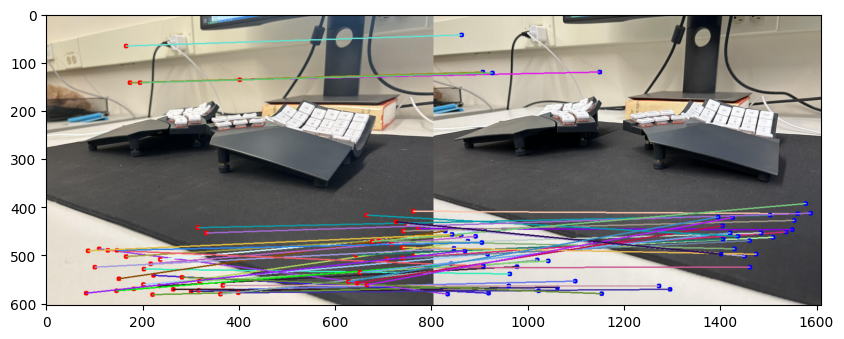

In [396]:
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Concatenate the images horizontally
combined_image = np.hstack((img1, img2))

for point_pair in corner_matches:
    # Point pair is a list of points [(y,x), (y,x), (y,x),..]
    # CV2 circle and line methods require points in (x,y) format
    # Since we concatenate the images, point2 values need a horizontal offset
    point1 = (point_pair[0][1], point_pair[0][0])
    point2 = (point_pair[1][1]+img1.shape[1], point_pair[1][0])

    cv2.circle(combined_image, point1, radius=5, color=(0, 0, 255), thickness=-1)
    cv2.circle(combined_image, point2, radius=5, color=(255, 0, 0), thickness=-1)
    
    line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(combined_image, point1, point2, color=line_color, thickness=2)

# cv2.imwrite(output_prefix + output_folder + img_key + "_matches_" + str(sigma).replace(".", "") + ".jpg", combined_image)
combined_image = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(combined_image)
plt.show()

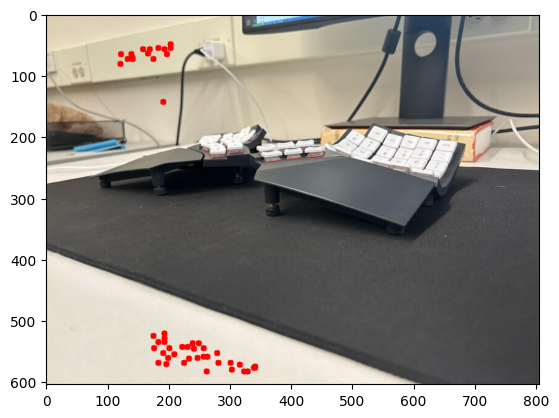

In [377]:
img1 = cv2.imread(img1_path)
for point_pair in corner_matches:
    # Point pair is a list of points
    # Since we concatenate the images, point2 values need a horizontal offset
    point1 = (point_pair[0][1], point_pair[0][0])
    # point2 = (point_pair[1][0]+img1.shape[1], point_pair[1][1])
    # point1 = (point_pair[1], point_pair[0])

    cv2.circle(img1, point1, radius=5, color=(0, 0, 255), thickness=-1)

# cv2.imwrite(output_prefix + output_folder + img_key + "1_" + str(sigma).replace(".", "") + ".jpg", img1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

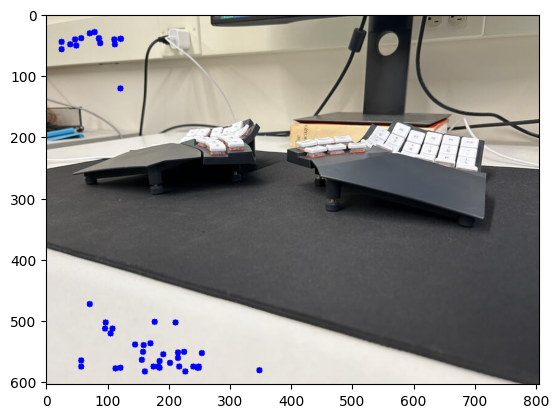

In [378]:
img2 = cv2.imread(img2_path)
for point_pair in corner_matches:
    # Point pair is a list of points
    # Since we concatenate the images, point2 values need a horizontal offset
    # point1 = point_pair[0]
    point2 = (point_pair[1][1], point_pair[1][0])
    # point2 = (point_pair[1], point_pair[0])

    cv2.circle(img2, point2, radius=5, color=(255, 0, 0), thickness=-1)

# cv2.imwrite(output_prefix + output_folder + img_key + "2_" + str(sigma).replace(".", "") + ".jpg", img2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

Test other corner detection tools

In [10]:
path_prefix = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW4/HW4_Images/"
output_prefix = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW4/HW4_Image_outputs/"
k=0.05
img_keys = ["key", "hovde_", "temple_", "rvl"]
sigmas=[5.0, 0.9, 1.2, 1.5, 0.6]

In [7]:
# Code is from the OpenCV tutorial for SIFT
for img_key in img_keys:
    img1_path = path_prefix + img_key + "1.jpg"
    img2_path = path_prefix + img_key + "2.jpg"
    
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    img1_bw = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) / 255
    img2_bw = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) / 255

    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw matches
    matched_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    cv2.imwrite("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW4/SIFT/" + img_key + "sift_match.jpg", matched_img)